# Prediction stock returns with linear regression

## Imports & Settings

In [111]:
import warnings
warnings.filterwarnings('ignore')

In [112]:
%matplotlib inline

from time import time
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [113]:
sns.set_style('darkgrid')
idx = pd.IndexSlice

In [114]:
YEAR = 252

## Load Data

In [115]:
with pd.HDFStore('data.h5') as store:
    data = (store['model_data']
            .dropna()
            .drop(['open', 'close', 'low', 'high'], axis=1))

In [116]:
data.index.names = ['symbol', 'date']

In [117]:
data = data.drop([c for c in data.columns if 'lag' in c], axis=1)

### Select Investment Universe

In [118]:
data = data[data.dollar_vol_rank<100]

In [119]:
data.info(show_counts=True)
data

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 109675 entries, ('AAL', Timestamp('2013-07-25 00:00:00')) to ('ZTS', Timestamp('2014-12-04 00:00:00'))
Data columns (total 45 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   volume                 109675 non-null  float64
 1   dollar_vol             109675 non-null  float64
 2   dollar_vol_1m          109675 non-null  float64
 3   dollar_vol_rank        109675 non-null  float64
 4   rsi                    109675 non-null  float64
 5   bb_high                109675 non-null  float64
 6   bb_low                 109675 non-null  float64
 7   atr                    109675 non-null  float64
 8   macd                   109675 non-null  float64
 9   return_1d              109675 non-null  float64
 10  return_5d              109675 non-null  float64
 11  return_10d             109675 non-null  float64
 12  return_21d             109675 non-null  float64
 13  return_42d    

volume     dollar_vol  dollar_vol_1m  dollar_vol_rank  \
symbol date                                                                     
AAL    2013-07-25  9851.900173  482021.770518  223614.661574             91.0   
       2013-07-26  7797.700026  386784.252060  234821.351626             83.0   
       2013-07-29  6462.699829  322916.026692  243001.954091             78.0   
       2013-07-30  6091.900156  303913.741002  243122.621493             79.0   
       2013-07-31  9571.100178  481215.006566  256336.659780             75.0   
...                        ...            ...            ...              ...   
ZTS    2014-11-28  1332.156000   58600.308107  294715.115434             90.0   
       2014-12-01  3153.115000  136973.841193  297525.671580             92.0   
       2014-12-02  2500.597000  109533.781479  298272.515355             88.0   
       2014-12-03  2008.310000   88245.383471  295315.035852             87.0   
       2014-12-04  4294.633000  185006.560464  286390.276661             95.0   

                         rsi   bb_high    bb_low       atr      macd  \
symbol date                                                            
AAL    2013-07-25  69.669475  0.011251  0.140777 -0.383445  0.681257   
       2013-07-26  72.045207  0.007052  0.146370 -0.412740  0.772848   
       2013-07-29  73.259776  0.008843  0.146963 -0.494894  0.854980   
       2013-07-30  72.532538  0.018500  0.142355 -0.565684  0.904814   
       2013-07-31  73.926238  0.016465  0.139949 -0.653399  0.954135   
...                      ...       ...       ...       ...       ...   
ZTS    2014-11-28  71.884144  0.043559  0.157493  0.397024  2.806829   
       2014-12-01  67.137279  0.051976  0.131103  0.403122  2.691178   
       2014-12-02  68.612084  0.041573  0.120638  0.323857  2.615256   
       2014-12-03  69.175766  0.038192  0.111125  0.236555  2.540352   
       2014-12-04  61.677853  0.051743  0.080568  0.273293  2.329735   

                   return_1d  ...  consumer_durables  consumer_non-durables  \
symbol date                   ...                                             
AAL    2013-07-25   0.017838  ...              False                  False   
       2013-07-26   0.013808  ...              False                  False   
       2013-07-29   0.007334  ...              False                  False   
       2013-07-30  -0.001560  ...              False                  False   
       2013-07-31   0.007813  ...              False                  False   
...                      ...  ...                ...                    ...   
ZTS    2014-11-28   0.005820  ...              False                  False   
       2014-12-01  -0.012464  ...              False                  False   
       2014-12-02   0.008339  ...              False                  False   
       2014-12-03   0.003129  ...              False                  False   
       2014-12-04  -0.019608  ...              False                  False   

                   consumer_services  energy  finance  health_care  \
symbol date                                                          
AAL    2013-07-25              False   False    False        False   
       2013-07-26              False   False    False        False   
       2013-07-29              False   False    False        False   
       2013-07-30              False   False    False        False   
       2013-07-31              False   False    False        False   
...                              ...     ...      ...          ...   
ZTS    2014-11-28              False   False    False         True   
       2014-12-01              False   False    False         True   
       2014-12-02              False   False    False         True   
       2014-12-03              False   False    False         True   
       2014-12-04              False   False    False         True   

                   miscellaneous  public_utilities  technology  transportation  
symbol date  

### Create Model Data

In [120]:
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume', 'consumer_durables'], axis=1)

## Custom MultipleTimeSeriesCV

In [121]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values('date').unique()
        days = sorted(unique_dates, reverse=True)

        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[['date']]
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[(dates.date > days[train_start])
                              & (dates.date <= days[train_end])].index
            test_idx = dates[(dates.date > days[test_start])
                             & (dates.date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

### Verify that it works

In [122]:
train_period_length = 63
test_period_length = 10
n_splits = int(3 * YEAR/test_period_length)
lookahead =1 

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [123]:
i = 0
for train_idx, test_idx in cv.split(X=data):
    train = data.iloc[train_idx]
    train_dates = train.index.get_level_values('date')
    test = data.iloc[test_idx]
    test_dates = test.index.get_level_values('date')
    df = pd.concat([train.reset_index(), test.reset_index()])
    n = len(df)
    assert n == len(df.drop_duplicates())
    print(train.groupby(level='symbol').size().value_counts().index[0],
          train_dates.min().date(), train_dates.max().date(),
          test.groupby(level='symbol').size().value_counts().index[0],
          test_dates.min().date(), test_dates.max().date())
    i += 1
    if i == 10:
        break

63 2017-08-16 2017-11-14 10 2017-11-15 2017-11-29
63 2017-08-02 2017-10-30 10 2017-10-31 2017-11-14
63 2017-07-19 2017-10-16 10 2017-10-17 2017-10-30
63 2017-07-05 2017-10-02 10 2017-10-03 2017-10-16
63 2017-06-20 2017-09-18 10 2017-09-19 2017-10-02
63 2017-06-06 2017-09-01 10 2017-09-05 2017-09-18
63 2017-05-22 2017-08-18 10 2017-08-21 2017-09-01
63 2017-05-08 2017-08-04 10 2017-08-07 2017-08-18
63 2017-04-24 2017-07-21 10 2017-07-24 2017-08-04
62 2017-04-10 2017-07-07 10 2017-07-10 2017-07-21


## Visualization helper functions

### Prediction vs Actual Scatter Plot

In [124]:
def plot_preds_scatter(df, ticker=None):
    if ticker is not None:
        idx = pd.IndexSlice
        df = df.loc[idx[ticker, :], :]
    j = sns.jointplot(x='predicted', y='actuals',
                      robust=True, ci=None,
                      line_kws={'lw': 1, 'color': 'k'},
                      scatter_kws={'s': 1},
                      data=df,
                      kind='reg')
    j.ax_joint.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    j.ax_joint.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
    j.ax_joint.set_xlabel('Predicted')
    j.ax_joint.set_ylabel('Actuals')

### Daily IC Distribution

In [125]:
# def plot_ic_distribution(df, ax=None):
#     if ax is not None:
#         sns.displot(df.ic, ax=ax)
#     else:
#         ax = sns.displot(df.ic)
#     mean, median = df.ic.mean(), df.ic.median()
#     ax.axvline(0, lw=1, ls='--', c='k')
#     ax.text(x=.05, y=.9,
#             s=f'Mean: {mean:8.2f}\nMedian: {median:5.2f}',
#             horizontalalignment='left',
#             verticalalignment='center',
#             transform=ax.transAxes)
#     ax.set_xlabel('Information Coefficient')
#     sns.despine()
#     plt.tight_layout()
    
    
def plot_ic_distribution(df, ax=None):
    if ax is not None:
        # If an axes is provided, use it directly for the histogram plotting
        sns.histplot(df.ic, ax=ax, kde=True) # sns.histplot is more appropriate for distribution on a single ax
        g = None # No FacetGrid created here
    else:
        # If no axes is provided, sns.displot creates a FacetGrid
        g = sns.displot(df.ic, kde=True)
        # Access the single axes object from the FacetGrid
        ax = g.axes.flatten()[0] # FacetGrid.axes is a 2D array of axes

    mean, median = df.ic.mean(), df.ic.median()

    # Now ax is guaranteed to be an Axes object, so axvline will work
    ax.axvline(0, lw=1, ls='--', c='k')
    ax.text(x=.05, y=.9,
            s=f'Mean: {mean:8.2f}\nMedian: {median:5.2f}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    ax.set_xlabel('Information Coefficient')
    sns.despine()

    # plt.tight_layout() should be called only if a new figure is created or
    # if you are managing the figure explicitly. When using an existing ax,
    # the layout is usually handled by the subplot containing that ax.
    # If 'g' exists (sns.displot was called), it handles its own layout.
    if g is None: # Only call tight_layout if an ax was passed in and no FacetGrid was created
        plt.tight_layout()

### Rolling Daily IC

In [126]:
def plot_rolling_ic(df):
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(14, 8))
    rolling_result = df.sort_index().rolling(21).mean().dropna()
    mean_ic = df.ic.mean()
    rolling_result.ic.plot(ax=axes[0],
                           title=f'Information Coefficient (Mean: {mean_ic:.2f})',
                           lw=1)
    axes[0].axhline(0, lw=.5, ls='-', color='k')
    axes[0].axhline(mean_ic, lw=1, ls='--', color='k')

    mean_rmse = df.rmse.mean()
    rolling_result.rmse.plot(ax=axes[1],
                             title=f'Root Mean Squared Error (Mean: {mean_rmse:.2%})',
                             lw=1,
                             ylim=(0, df.rmse.max()))
    axes[1].axhline(df.rmse.mean(), lw=1, ls='--', color='k')
    sns.despine()
    plt.tight_layout()

## Linear Regression with sklearn

### Set up cross-validation

Our data consists of numerous time series, one for each security. As discussed in *Chapter 6, The Machine Learning Process*, sequential data like time series requires careful cross-validation to be set up so that we do not inadvertently introduce look-ahead bias or leakage. 

We can achieve this using the `MultipleTimeSeriesCV` class that we introduced in *Chapter 6, The Machine Learning Process*. We initialize it with the desired lengths for the train and test periods, the number of test periods that we would like to run, and the number of periods in our forecasting horizon. The `split()` method returns a generator yielding pairs of train and test indices, which we can then use to select outcomes and features. The number of pairs depends on the parameter n_splits.

The test periods do not overlap and are located at the end of the period available in the data. After a test period is used, it becomes part of the training data that rolls forward and remains constant in size.

We will test this using 63 trading days, or 3 months, to train the model and then predict 1-day returns for the following 10 days. As a result, we can use around 75 10-day splits during the 3 years, starting in

In [127]:
train_period_length = 63
test_period_length = 10
n_splits = int(3 * YEAR / test_period_length)
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

### Run cross-validation with LinearRegression 

The cross-validation loop iterates over the train and test indices provided by `TimeSeriesCV`,selects features and outcomes, trains the model, and predicts the returns for the test features. We also capture the root mean squ

In [128]:
%%time
target = f'target_{lookahead}d'
lr_predictions, lr_scores = [], []
lr = LinearRegression()
for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
    X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]
    lr.fit(X=X_train, y=y_train)
    y_pred = lr.predict(X_test)

    preds = y_test.to_frame('actuals').assign(predicted=y_pred)
    preds_by_day = preds.groupby(level='date')
    scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                               x.actuals)[0] * 100)
                        .to_frame('ic'),
                        preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                y_true=x.actuals)))
                        .to_frame('rmse')], axis=1)

    lr_scores.append(scores)
    lr_predictions.append(preds)

lr_scores = pd.concat(lr_scores)
lr_predictions = pd.concat(lr_predictions)

CPU times: user 6.59 s, sys: 10.5 s, total: 17.1 s
Wall time: 1.16 s


In [129]:
lr_predictions

actuals  predicted
symbol date                           
AAPL   2017-11-15  0.011947  -0.001070
       2017-11-16 -0.005552  -0.000177
       2017-11-17 -0.000999  -0.000833
       2017-11-20  0.018590  -0.000467
       2017-11-21  0.010512   0.000103
...                     ...        ...
XOM    2014-12-16  0.030205  -0.001093
       2014-12-17  0.024040  -0.001359
       2014-12-18  0.027205  -0.000944
       2014-12-19 -0.003311  -0.001867
       2014-12-22  0.013500  -0.002199

[74054 rows x 2 columns]

In [130]:
lr_scores

,ic,rmse
date,,
2017-11-15,14.975550,0.019839
2017-11-16,-26.598103,0.011923
2017-11-17,38.779336,0.010337
2017-11-20,35.754771,0.012877
2017-11-21,-39.360786,0.009570
...,...,...
2014-12-16,-14.317873,0.031289
2014-12-17,31.454545,0.028132
2014-12-18,-44.676562,0.021422


### Persist results

In [131]:
lr_scores.to_hdf('data.h5', 'lr/scores')
lr_predictions.to_hdf('data.h5', 'lr/predictions')

In [132]:
lr_scores = pd.read_hdf('data.h5', 'lr/scores')
lr_predictions = pd.read_hdf('data.h5', 'lr/predictions')

### Evaluate results

In [133]:
lr_r, lr_p = spearmanr(lr_predictions.actuals, lr_predictions.predicted)
print(f'Information Coefficient (overall): {lr_r:.3%} (p-value: {lr_p:.4%})')

Information Coefficient (overall): 1.531% (p-value: 0.0031%)


#### Prediction vs Actuals Scatter

We have captured 3 years of daily test predictions for our universe. To evaluate the model's predictive performance, we can compute the information coefficient for each trading day, as well as for the entire period by pooling all forecasts.

The following figure shows a scatterplot of the predicted and actual 1-day returns across all test periods. The seaborn jointplot estimates a robust regression that assigns lower weights to outliers and shows a small positive relationship. The rank correlation of actual and predicted returns for the entire 3-year test period is positive but low at 0.017 and statistically significant:

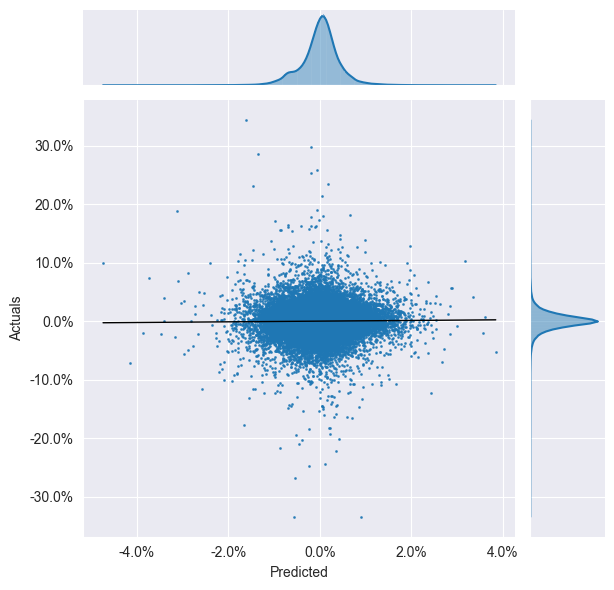

In [134]:
plot_preds_scatter(lr_predictions)

#### Daily IC Distribution

The following Figure 7.6 (see the code in the notebook) shows the distribution of the rank correlation coefficients computed for each day and displays their mean and median, which are close to 1.86 and 1.98, respectively.

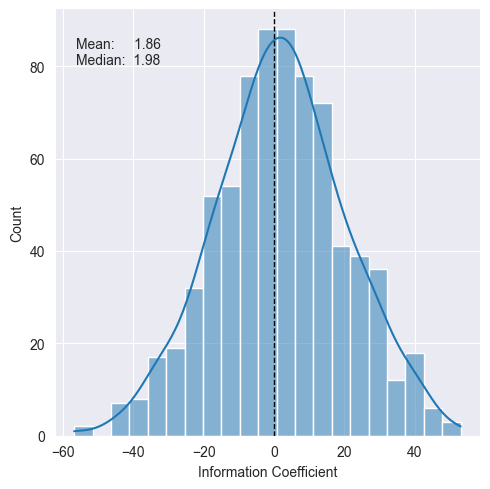

In [135]:
plot_ic_distribution(lr_scores)

#### How to Read the Resulting Plot

The plot provides insights into the linear regression model's performance in ranking stock returns. Here's how to interpret it:

1. **Shape of the Distribution**:

    - The histogram or KDE shows the frequency (or density) of IC values across all test days.

    - **Positive Skew**: If the distribution is centered to the right of 0, the model tends to have positive predictive power (predictions align with actual returns).

    - **Centered at 0**: If the distribution peaks near 0, the model has little to no predictive ability on average.

    - **Negative Skew**: If centered to the left of 0, the model often ranks returns incorrectly.

2. **Vertical Line at 0**:

    - This line divides positive and negative IC values. A distribution mostly to the right of this line indicates better-than-random performance; to the left indicates worse-than-random.

3. **Mean and Median**:

    - **Mean IC**: The average daily IC. A positive value suggests overall predictive power, while a value near 0 or negative suggests poor performance.

    - **Median IC**: The typical IC, less affected by outliers. Comparing it to the mean can reveal skewness (e.g., if the mean is higher, there may be a few days with very high IC).

4. **Spread of the Distribution**:

    - A narrow distribution indicates consistent performance across days.

    - A wide spread suggests variability---some days the model performs well, others poorly.

---

#### Example Interpretation

Suppose the plot shows:

- A distribution slightly right of 0, with a mean IC of 1.5 and a median of 1.0.

- A wide spread, ranging from -20 to 25.

This would suggest:

- The model has weak but positive predictive power on average (mean IC = 1.5).

- Performance is inconsistent (wide range), with some days showing strong positive IC and others negative.

- The median being lower than the mean indicates a few outlier days with high IC pulling the average up.

---

#### Purpose in Context

In the given code, `lr_scores` aggregates IC values from multiple cross-validation folds, so the plot reflects the model's overall ranking ability across all test periods. It helps assess:

- **Consistency**: How stable is the model's performance day-to-day?

- **Strength**: Does the model consistently rank stocks correctly (positive IC)?

- **Practicality**: Is the predictive power strong enough for real-world use?

For a linear regression model with weak predictive power (e.g., a rank correlation of 0.017 as hinted earlier), you'd expect a distribution centered slightly above 0 with significant variability, indicating limited practical utility despite some statistical significance.

---

### Summary

`plot_ic_distribution(lr_scores)` visualizes the distribution of daily Information Coefficients from a linear regression model's predictions. It uses a histogram or KDE to show how often the model correctly ranks stock returns, with a reference line at 0 and text displaying the mean and median IC. The resulting plot helps evaluate the model's consistency and predictive strength, typically revealing a weak but positive average performance with notable day-to-day variation in this context.

#### Rolling Daily IC

In addition, we can track how predictions performed in terms of the IC on a daily basis. Figure 7.7 displays a 21-day rolling average for both the daily information coefficient and the RMSE, as well as their respective means for the validation period. This perspective highlights that the small positive IC for the entire period hides substantial variation that ranges from -10 to +10:

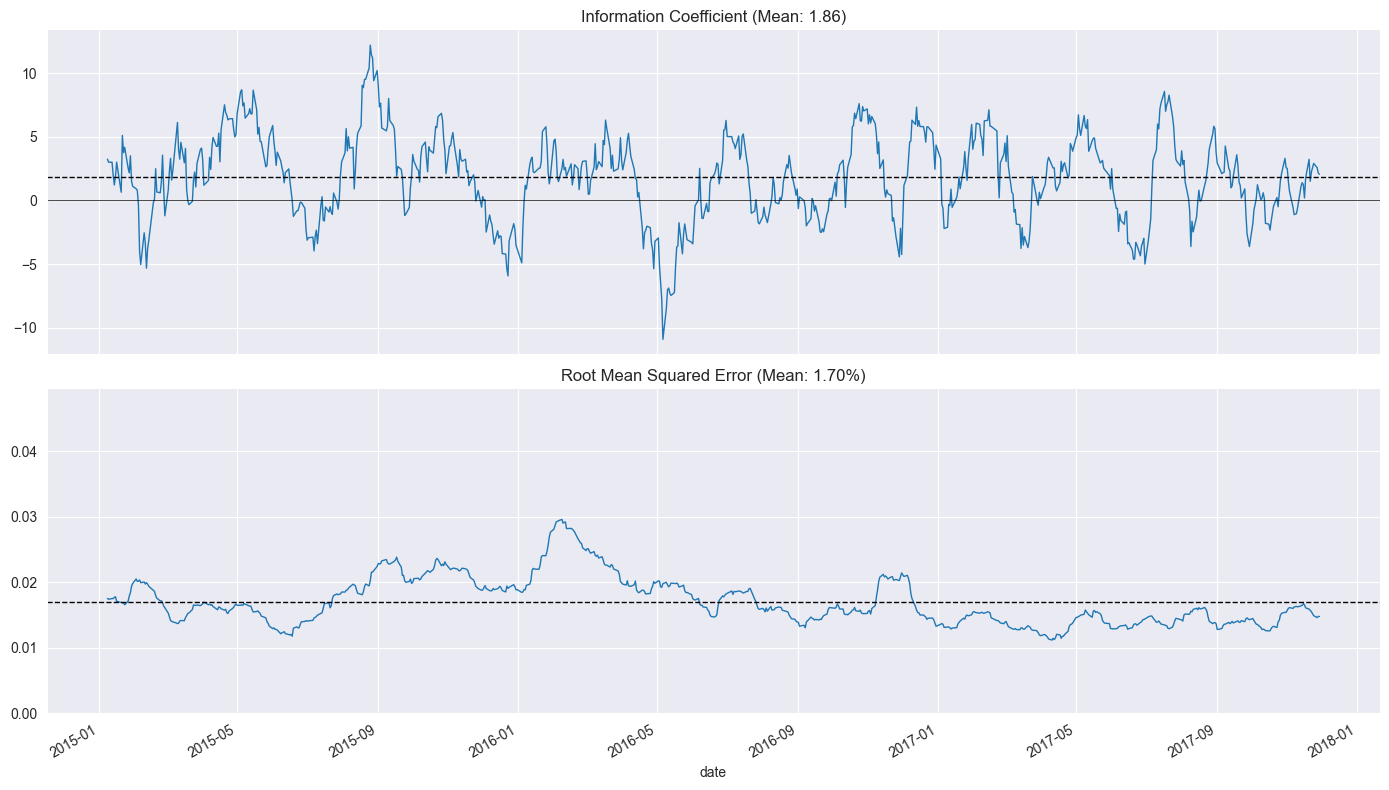

In [136]:
plot_rolling_ic(lr_scores)

-   **Top Panel: Rolling IC**:
    -   **What You See**: A line showing the 21-day rolling average of IC over time.
        -   **Positive Values**: The model's predictions correctly rank stock returns (higher is better).
        -   **Negative Values**: The model's rankings are inversely related to actual returns (lower is worse).
        -   **Fluctuations**: Indicate how the model's ranking ability changes over time.
    -   **Reference Lines**:
        -   **Solid Line at 0**: No predictive power (random ranking).
        -   **Dashed Line at Mean IC**: The overall average IC for comparison.
    -   **Key Insight**: The query notes that the IC ranges from -10 to +10, despite a small positive overall mean. This means the model's ranking ability varies widely, and the plot reveals these ups and downs that the average hides.

-   **Bottom Panel: Rolling RMSE**:
    -   **What You See**: A line showing the 21-day rolling average of RMSE over time.
        -   **Lower Values**: More accurate predictions (smaller errors).
        -   **Higher Values**: Less accurate predictions (larger errors).
    -   **Reference Line**: The dashed line at the mean RMSE shows the average error level.
    -   **Key Insight**: Trends or spikes in RMSE indicate periods when the model's predictions were more or less accurate, which might relate to market conditions or model limitations.

## Ridge Regression

We will now move on to the regularized ridge model, which we will use to evaluate whether parameter constraints improve on the linear regression's predictive performance. Using the ridge model allows us to select the hyperparameter that determines the weight of the penalty term in the model's objective function, as discussed previously in the section *Shrinkage methods: regularization for linear regression*.

### Define cross-validation parameters

For ridge regression, we need to tune the regularization parameter with the keyword `alpha`, which corresponds to the λ we used previously. We will try 18 values from $10^{-4}$ to $10^{4}$, where larger values imply stronger regularization:

In [137]:
ridge_alphas = np.logspace(-4, 4, 9)
ridge_alphas = sorted(list(ridge_alphas) + list(ridge_alphas * 5))

We will apply the same cross-validation parameters as in the linear regression case, training for 3 months to predict 10 days of daily returns.

In [138]:
n_splits = int(3 * YEAR/test_period_length)
train_period_length = 63
test_period_length = 10
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

### Run cross-validation

In [139]:
target = f'target_{lookahead}d'

X = X.drop([c for c in X.columns if 'year' in c], axis=1)

The scale sensitivity of the ridge penalty requires us to standardize the inputs. We use a `Pipeline` that includes `StandardScaler` to handle this preprocessing automatically. During training, the Pipeline applies the .`fit_transform()` method of `StandardScaler` to the training data, learning the mean and standard deviation, and then fits the Ridge model to the scaled data. For predictions, it applies the `.transform()` method to the test data using the parameters learned from the training set, ensuring consistency and preventing data leakage. This automation simplifies the workflow. We also collect the ridge coefficients. Otherwise, the cross-validation process resembles that of linear regression.

In [140]:
%%time
# Initialize empty structures to store coefficients, scores, and predictions for each alpha
ridge_coeffs, ridge_scores, ridge_predictions = {}, [], []

# Iterate over different regularization strengths (alphas) for Ridge regression
for alpha in ridge_alphas:
    # Print the current alpha to track progress
    print(alpha, end=' ', flush=True)
    # Record the start time for this alpha
    start = time()
    # Create a Ridge model with the current alpha, no intercept 
    # (since data is standardized), and fixed random state
    model = Ridge(alpha=alpha, fit_intercept=False, random_state=42)
    # Set up a pipeline to standardize features and apply the Ridge model
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])
    # Initialize a list to store coefficients for each fold
    coeffs = []
    # Perform time-series cross-validation to respect the temporal structure of the data
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        # Split the data into training and test sets using the cross-validator
        X_train, y_train = X.iloc[train_idx], y[target].iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]
        # Fit the pipeline on the training data (standardizes and fits the model)
        pipe.fit(X=X_train, y=y_train)
        # Predict on the test data (standardizes and predicts)
        y_pred = pipe.predict(X_test)
        # Create a DataFrame with actual and predicted values for evaluation
        preds = y_test.to_frame('actuals').assign(predicted=y_pred)
        # Group predictions by date to calculate daily performance metrics
        preds_by_day = preds.groupby(level='date')
        # Calculate daily Information Coefficient (IC) to measure ranking ability
        # and Root Mean Squared Error (RMSE) to measure prediction accuracy
        scores = pd.concat([
            preds_by_day.apply(lambda x: 
                spearmanr(x.predicted, x.actuals)[0] * 100).to_frame('ic'),
            preds_by_day.apply(lambda x: 
                np.sqrt(mean_squared_error(y_pred=x.predicted, y_true=x.actuals))).to_frame('rmse')
        ], axis=1)
        # Append daily scores with the current alpha to the list for later analysis
        ridge_scores.append(scores.assign(alpha=alpha))
        # Append predictions with the current alpha to the list for later analysis
        ridge_predictions.append(preds.assign(alpha=alpha))
        # Append the model coefficients for this fold to analyze feature importance
        coeffs.append(pipe.named_steps['model'].coef_)
    # Calculate the mean coefficients across all folds for this alpha to get a stable estimate
    ridge_coeffs[alpha] = np.mean(coeffs, axis=0)

# Print a newline to separate output for different alphas
print('\n')

0.0001 0.0005 0.001 0.005 0.01 0.05 0.1 0.5 1.0 5.0 10.0 50.0 100.0 500.0 1000.0 5000.0 10000.0 50000.0 

CPU times: user 59 s, sys: 4min 19s, total: 5min 18s
Wall time: 21.2 s


### Explanation of the Inline Comments

- **Timing and Initialization**:
  - `%%time`: Indicates that the cell's execution time will be measured (Jupyter magic command).
  - The first line initializes a dictionary (`ridge_coeffs`) for coefficients, and lists (`ridge_scores`, `ridge_predictions`) for scores and predictions, setting up storage for results across different `alpha` values.

- **Outer Loop Over Alphas**:
  - The `for` loop iterates over `ridge_alphas`, testing different regularization strengths for the Ridge regression model.
  - `print(alpha, end=' ', flush=True)`: Outputs the current `alpha` to monitor progress, with `flush=True` ensuring immediate display.
  - `start = time()`: Captures the start time to potentially track duration (though not used here).

- **Model and Pipeline Setup**:
  - `Ridge(alpha=alpha, fit_intercept=False, random_state=42)`: Creates a Ridge regression model with the current `alpha`. The `fit_intercept=False` is used because the data will be standardized (centered), making an intercept redundant. `random_state=42` ensures reproducibility.
  - `Pipeline([...])`: Combines feature standardization (`StandardScaler`) and the Ridge model into a single workflow, ensuring preprocessing and modeling are applied consistently.

- **Cross-Validation Loop**:
  - `coeffs = []`: Initializes a list to collect coefficients from each fold.
  - `cv.split(X)`: Assumes a time-series-aware cross-validator (e.g., `TimeSeriesSplit`) to split the data while preserving temporal order.
  - The inner `for` loop performs cross-validation, iterating over training and test indices.

- **Data Splitting and Model Fitting**:
  - Data is split into training (`X_train`, `y_train`) and test (`X_test`, `y_test`) sets using the indices from the cross-validator.
  - `pipe.fit(...)`: Fits the pipeline, which standardizes the training features and trains the Ridge model.
  - `pipe.predict(...)`: Applies standardization to test features and generates predictions.

- **Performance Evaluation**:
  - `preds = ...`: Creates a DataFrame with actual and predicted values for comparison.
  - `preds_by_day = preds.groupby(level='date')`: Groups results by date, assuming a multi-index with a 'date' level, to compute daily metrics.
  - `scores = pd.concat([...])`: Calculates:
    - **Information Coefficient (IC)**: Spearman correlation between predictions and actuals, multiplied by 100 for percentage, assessing ranking ability.
    - **Root Mean Squared Error (RMSE)**: Square root of the mean squared error, measuring prediction accuracy.

- **Storing Results**:
  - Scores and predictions are tagged with the current `alpha` and appended to their respective lists for later analysis.
  - Coefficients from each fold are stored in `coeffs` to examine feature importance.

- **Post-Processing**:
  - `ridge_coeffs[alpha] = np.mean(coeffs, axis=0)`: Averages coefficients across folds for each `alpha`, providing a stable estimate of feature impacts.
  - `print('\n')`: Adds a newline to separate output for different `alpha` values, improving readability.

These comments provide a clear, step-by-step guide to the code's purpose—evaluating a Ridge regression model on time-series data (e.g., stock returns) using cross-validation, with performance assessed via daily IC and RMSE metrics.

### Persist results

In [141]:
ridge_scores = pd.concat(ridge_scores)
ridge_scores.to_hdf('data.h5', 'ridge/scores')

ridge_coeffs = pd.DataFrame(ridge_coeffs, index=X.columns).T
ridge_coeffs.to_hdf('data.h5', 'ridge/coeffs')

ridge_predictions = pd.concat(ridge_predictions)
ridge_predictions.to_hdf('data.h5', 'ridge/predictions')

In [142]:
ridge_scores = pd.read_hdf('data.h5', 'ridge/scores')
ridge_coeffs = pd.read_hdf('data.h5', 'ridge/coeffs')
ridge_predictions = pd.read_hdf('data.h5', 'ridge/predictions')

### Evaluate Ridge Results

In [143]:
ridge_r, ridge_p = spearmanr(ridge_predictions.actuals, ridge_predictions.predicted)
print(f'Information Coefficient (overall): {ridge_r:.3%} (p-value: {ridge_p:.4%})')

Information Coefficient (overall): 1.551% (p-value: 0.0000%)


#### **Explanation:**

-   **What it does**:
    -   The spearmanr function from the scipy.stats library calculates the Spearman rank correlation coefficient (ridge_r) and its associated p-value (ridge_p) between two arrays: ridge_predictions.actuals (actual values) and ridge_predictions.predicted (predicted values from the Ridge regression model).
    -   The Spearman correlation assesses the monotonic relationship between actual and predicted values, making it suitable for ranking performance (e.g., whether stocks with higher predicted returns have higher actual returns).
-   **Output interpretation**:
    -   **IC = 1.551%**: The overall Information Coefficient is 1.551%, meaning there's a very weak positive correlation between the predicted and actual values across all predictions. In financial modeling, IC values are often small, but this is particularly low, suggesting limited practical ranking ability.
    -   **p-value = 0.0000%**: The p-value is effectively zero (highly significant), indicating that the correlation is unlikely to occur by chance. However, statistical significance doesn't imply practical usefulness, given the small IC magnitude.

In [144]:
ridge_scores.groupby('alpha').ic.describe()

,count,mean,std,min,25%,50%,75%,max
alpha,,,,,,,,
0.0001,750.0,1.863889,18.565640,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.0005,750.0,1.863889,18.565640,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.0010,750.0,1.863889,18.565640,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.0050,750.0,1.863890,18.565617,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.0100,750.0,1.864012,18.565426,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.0500,750.0,1.864657,18.566158,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.1000,750.0,1.864743,18.566752,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.5000,750.0,1.863531,18.566137,-56.835055,-9.996599,1.966605,14.124337,53.034014
1.0000,750.0,1.863910,18.566893,-56.835055,-9.996599,1.966605,14.110091,53.161410


#### **Explanation:**

-   **What it does**:
    -   The ridge_scores DataFrame contains daily IC values (stored in the ic column) calculated for different alpha values (the regularization parameter in Ridge regression).
    -   The groupby('alpha').ic.describe() command groups the IC values by each alpha and computes descriptive statistics: count, mean, standard deviation (std), minimum (min), 25th percentile (25%), median (50%), 75th percentile (75%), and maximum (max).
    -   Alpha controls the strength of regularization: small alpha values mean weak regularization (closer to ordinary least squares), while large alpha values shrink coefficients more aggressively toward zero.
-   **Key observations**:
    -   **Count**: Each alpha has 750 observations (e.g., 750 days of data).
    -   **Mean IC**:
        -   For small alphas (e.g., 0.0001 to 0.1), the mean IC is around 1.86--1.87.
        -   It peaks at 1.927645 for alpha = 100, suggesting moderate regularization slightly improves ranking performance.
        -   For very large alphas (e.g., 10000 or 50000), the mean IC drops to 1.20 and 0.83, indicating excessive regularization harms performance.
    -   **Median IC**:
        -   Starts at 1.981447 for small alphas, peaks slightly, and then drops significantly (e.g., 0.072047 at alpha = 50000), showing a similar trend to the mean.
    -   **Variability**:
        -   The standard deviation is high (~18--19), and the range (min to max) is wide (e.g., -57 to +53 for alpha = 100), indicating the model's ranking ability fluctuates greatly across days.
    -   **Conclusion**: Moderate alpha values (e.g., around 100) yield the highest mean IC, but the model's performance is inconsistent due to high variability.

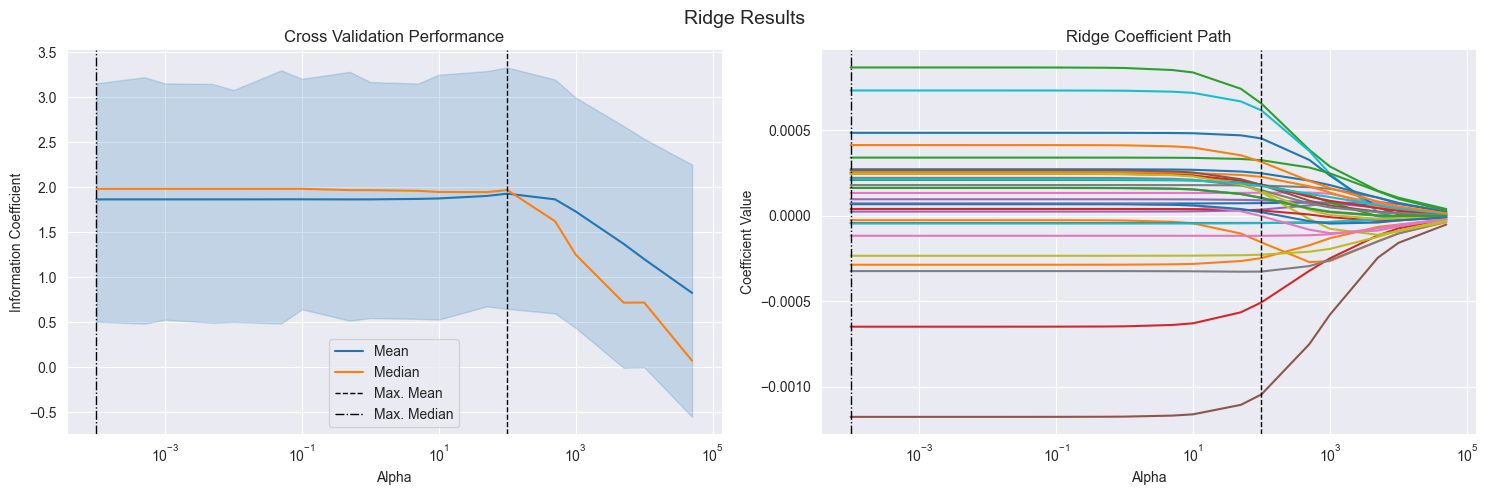

In [145]:
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

scores_by_alpha = ridge_scores.groupby('alpha').ic.agg(['mean', 'median'])
best_alpha_mean = scores_by_alpha['mean'].idxmax()
best_alpha_median = scores_by_alpha['median'].idxmax()

ax = sns.lineplot(x='alpha',
                  y='ic',
                  data=ridge_scores,
                  estimator=np.mean,
                  label='Mean',
                  ax=axes[0])

scores_by_alpha['median'].plot(logx=True,
                               ax=axes[0],
                               label='Median')

axes[0].axvline(best_alpha_mean,
                ls='--',
                c='k',
                lw=1,
                label='Max. Mean')
axes[0].axvline(best_alpha_median,
                ls='-.',
                c='k',
                lw=1,
                label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Information Coefficient')
axes[0].set_title('Cross Validation Performance')

ridge_coeffs.plot(logx=True,
                  legend=False,
                  ax=axes[1],
                  title='Ridge Coefficient Path')

axes[1].axvline(best_alpha_mean,
                ls='--',
                c='k',
                lw=1,
                label='Max. Mean')
axes[1].axvline(best_alpha_median,
                ls='-.',
                c='k',
                lw=1,
                label='Max. Median')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coefficient Value')

fig.suptitle('Ridge Results', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)

#### **Explanation:**

-   **What it does**:
    -   Creates a figure with two subplots to visualize the effect of alpha on IC and model coefficients:
        -   **Left Subplot (Cross Validation Performance)**:
            -   Plots the mean IC (blue line) and median IC (orange line) against alpha on a logarithmic scale (logx=True).
            -   Identifies the alpha values that maximize the mean IC (best_alpha_mean) and median IC (best_alpha_median) and marks them with vertical lines (dashed for mean, dash-dot for median).
            -   Labels the axes and adds a legend.
        -   **Right Subplot (Ridge Coefficient Path)**:
            -   Plots the Ridge regression coefficients (from ridge_coeffs) for each feature as a function of alpha on a log scale.
            -   Marks the same best_alpha_mean and best_alpha_median with vertical lines.
            -   Shows how coefficients shrink as alpha increases due to regularization.
-   **Interpretation**:
    -   **Left Subplot**:
        -   The mean IC peaks around alpha = 100 (based on the table, mean = 1.927645), and the median IC is relatively stable for smaller alphas before declining.
        -   The vertical lines help identify the optimal alpha values for maximizing IC.
    -   **Right Subplot**:
        -   As alpha increases, coefficients approach zero, reflecting Ridge regression's regularization effect.
        -   The best alpha values (e.g., around 100 for mean IC) correspond to a specific set of coefficients that balance model complexity and performance.
    -   **Purpose**: These plots aid in selecting an optimal alpha by showing how IC and coefficients change with regularization strength.

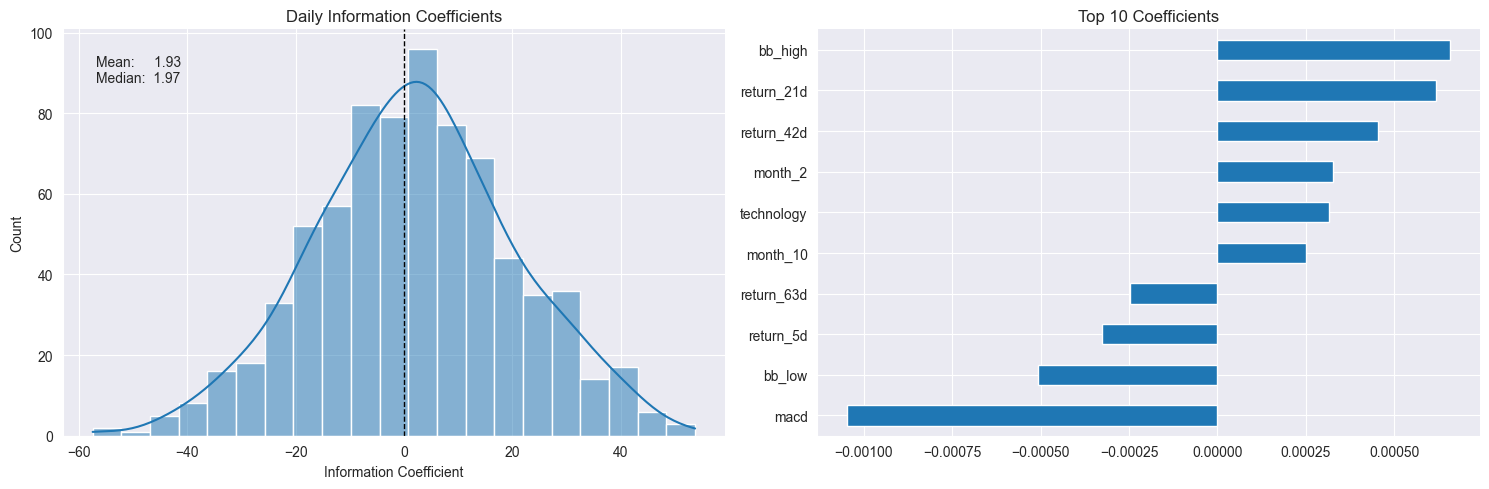

In [146]:
best_alpha = ridge_scores.groupby('alpha').ic.mean().idxmax()
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(ridge_scores[ridge_scores.alpha == best_alpha],
                     ax=axes[0])
axes[0].set_title('Daily Information Coefficients')
# top_coeffs = ridge_coeffs.loc[best_alpha].abs().sort_values().head(10).index  #THIS IS WRONG, IT'S NOT TOP 10, IT'S BOTTOM 10
# top_coeffs = ridge_coeffs.loc[best_alpha].abs().sort_values(ascending = False).head(10).index
top_coeffs = ridge_coeffs.loc[best_alpha].abs().nlargest(10).index
top_coeffs.tolist()
ridge_coeffs.loc[best_alpha, top_coeffs].sort_values().plot.barh(ax=axes[1],
                                                                 title='Top 10 Coefficients')
sns.despine()
fig.tight_layout()

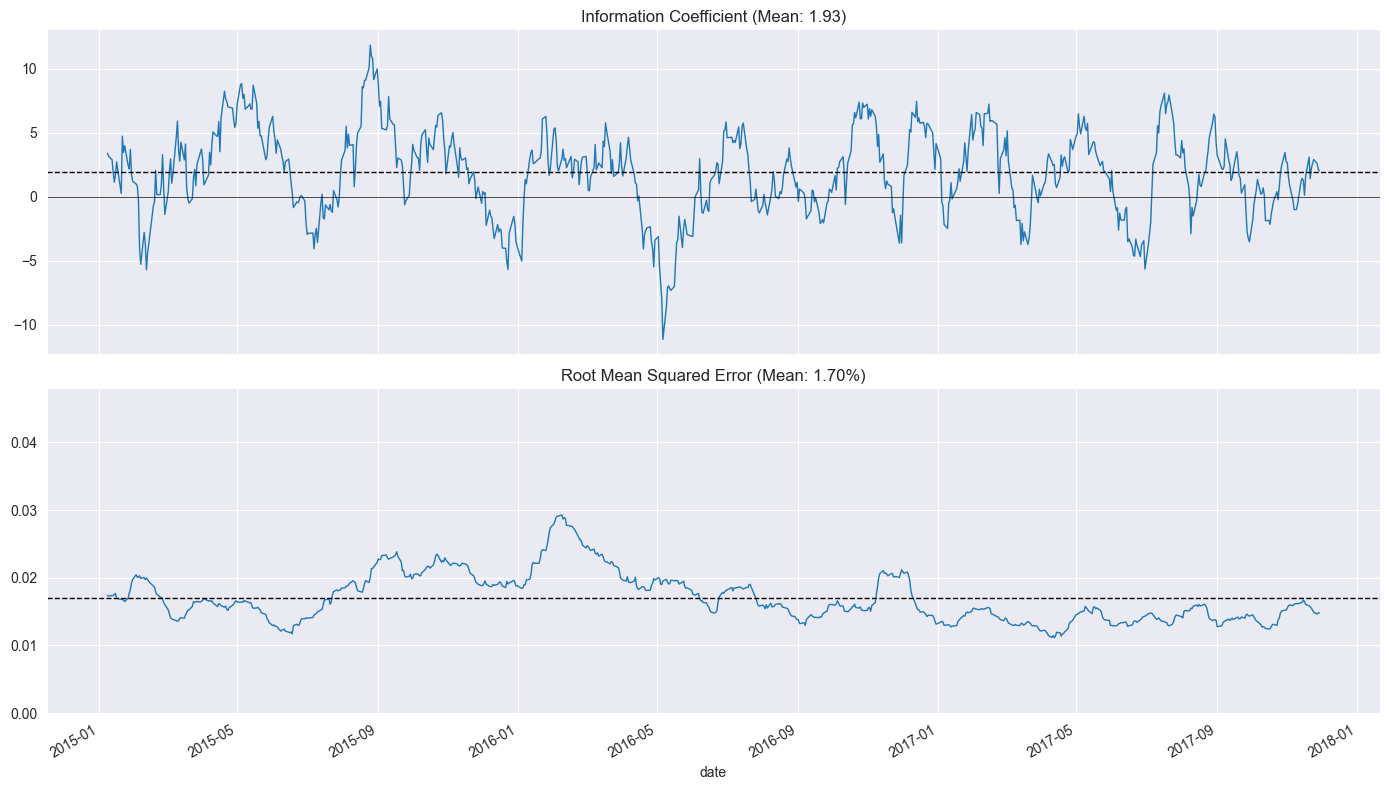

In [147]:
plot_rolling_ic(ridge_scores[ridge_scores.alpha==best_alpha])

## Lasso CV

### Define cross-validation parameters

In [148]:
lasso_alphas = np.logspace(-10, -3, 8)

In [149]:
train_period_length = 63
test_period_length = 10
YEAR = 252
n_splits = int(3 * YEAR / test_period_length) # three years
lookahead = 1

In [150]:
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

### Run cross-validation with Lasso regression

In [151]:
target = f'target_{lookahead}d'

scaler = StandardScaler()
X = X.drop([c for c in X.columns if 'year' in c], axis=1)

In [152]:
%%time

lasso_coeffs, lasso_scores, lasso_predictions = {}, [], []
for alpha in lasso_alphas:
    print(alpha, end=' ', flush=True)
    model = Lasso(alpha=alpha,
                  fit_intercept=False,  # StandardScaler centers data
                  random_state=42,
                  tol=1e-3,
                  max_iter=1000,
                  warm_start=True,
                  selection='random')

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])
    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        t = time()
        X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]

        pipe.fit(X=X_train, y=y_train)
        y_pred = pipe.predict(X_test)

        preds = y_test.to_frame('actuals').assign(predicted=y_pred)
        preds_by_day = preds.groupby(level='date')
        scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                                   x.actuals)[0] * 100)
                            .to_frame('ic'),
                            preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                    y_true=x.actuals)))
                            .to_frame('rmse')],
                           axis=1)

        lasso_scores.append(scores.assign(alpha=alpha))
        lasso_predictions.append(preds.assign(alpha=alpha))

        coeffs.append(pipe.named_steps['model'].coef_)

    lasso_coeffs[alpha] = np.mean(coeffs, axis=0)

1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 0.0001 0.001 CPU times: user 1min 27s, sys: 7min 22s, total: 8min 50s
Wall time: 35 s


In [153]:
lasso_coeffs

{np.float64(1e-10): array([-1.51959467e-05,  1.58277858e-03, -7.49427833e-04,  1.28785298e-03,
         3.97454745e-04, -2.79075174e-03, -4.05888580e-04, -1.31000603e-03,
        -3.88904379e-04, -6.18691543e-04, -1.46363569e-03,  2.23843778e-03,
         1.34583719e-03, -3.94115542e-04,  7.30240965e-04, -1.45192626e-03,
         7.53744358e-04,  2.35753367e-03,  1.19236855e-03, -3.61646474e-04,
         5.67911694e-04,  5.55827825e-04,  4.33839484e-04,  9.91560765e-04,
         1.38936950e-03,  1.55389712e-03, -1.41864412e-04,  1.51383276e-03,
         2.41528774e-03,  1.05198319e-03,  9.65707431e-04,  1.32083372e-03,
         1.90022452e-03]),
 np.float64(1e-09): array([-1.51930135e-05,  1.58277327e-03, -7.49392133e-04,  1.28782575e-03,
         3.97450998e-04, -2.79073802e-03, -4.05883160e-04, -1.30999178e-03,
        -3.88878344e-04, -6.18679025e-04, -1.46362674e-03,  2.23842500e-03,
         1.34583560e-03, -3.94115047e-04,  7.30238472e-04, -1.45221565e-03,
         7.51771856e-04

In [154]:
lasso_scores

[                   ic      rmse         alpha
 date                                         
 2017-11-15  14.975550  0.020270  1.000000e-10
 2017-11-16 -26.598103  0.011859  1.000000e-10
 2017-11-17  38.779336  0.010426  1.000000e-10
 2017-11-20  35.754771  0.013288  1.000000e-10
 2017-11-21 -39.360786  0.009613  1.000000e-10
 2017-11-22  21.918367  0.008282  1.000000e-10
 2017-11-24   5.470692  0.011496  1.000000e-10
 2017-11-27  -4.305415  0.017660  1.000000e-10
 2017-11-28  -7.855326  0.030645  1.000000e-10
 2017-11-29  11.662338  0.016340  1.000000e-10,
                    ic      rmse         alpha
 date                                         
 2017-10-31 -13.478569  0.014068  1.000000e-10
 2017-11-01   9.025878  0.015637  1.000000e-10
 2017-11-02 -23.299479  0.018157  1.000000e-10
 2017-11-03   0.569337  0.015560  1.000000e-10
 2017-11-06  -9.124062  0.012150  1.000000e-10
 2017-11-07 -24.791360  0.016995  1.000000e-10
 2017-11-09   5.409679  0.012201  1.000000e-10
 2017-11-10 

In [155]:
lasso_predictions

[                    actuals  predicted         alpha
 symbol date                                         
 AAPL   2017-11-15  0.011947  -0.001764  1.000000e-10
        2017-11-16 -0.005552  -0.000870  1.000000e-10
        2017-11-17 -0.000999  -0.001527  1.000000e-10
        2017-11-20  0.018590  -0.001161  1.000000e-10
        2017-11-21  0.010512  -0.000591  1.000000e-10
 ...                     ...        ...           ...
 XOM    2017-11-22  0.003946  -0.002621  1.000000e-10
        2017-11-24 -0.003807  -0.002316  1.000000e-10
        2017-11-27  0.006904  -0.002890  1.000000e-10
        2017-11-28  0.007347  -0.002172  1.000000e-10
        2017-11-29  0.012398  -0.001956  1.000000e-10
 
 [984 rows x 3 columns],
                     actuals  predicted         alpha
 symbol date                                         
 AAPL   2017-10-31 -0.012719   0.001865  1.000000e-10
        2017-11-01  0.007310   0.000230  1.000000e-10
        2017-11-02  0.026114  -0.000358  1.000000e-10
 

### Persist results

In [156]:
lasso_scores = pd.concat(lasso_scores)
lasso_scores.to_hdf('data.h5', 'lasso/scores')

lasso_coeffs = pd.DataFrame(lasso_coeffs, index=X.columns).T
lasso_coeffs.to_hdf('data.h5', 'lasso/coeffs')

lasso_predictions = pd.concat(lasso_predictions)
lasso_predictions.to_hdf('data.h5', 'lasso/predictions')

### Evaluate Lasso Results

In [157]:
best_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()
preds = lasso_predictions[lasso_predictions.alpha==best_alpha]

lasso_r, lasso_p = spearmanr(preds.actuals, preds.predicted)
print(f'Information Coefficient (overall): {lasso_r:.3%} (p-value: {lasso_p:.4%})')

Information Coefficient (overall): 3.595% (p-value: 0.0000%)


In [158]:
lasso_scores.groupby('alpha').ic.agg(['mean', 'median'])

,mean,median
alpha,,
1.000000e-10,1.863889,1.981447
1.000000e-09,1.863758,1.981447
1.000000e-08,1.864487,1.981447
1.000000e-07,1.865393,1.966605
1.000000e-06,1.875294,1.962276
1.000000e-05,1.935876,2.191108
1.000000e-04,1.575376,1.012989
1.000000e-03,1.025462,1.768092


### Lasso Coefficient Path

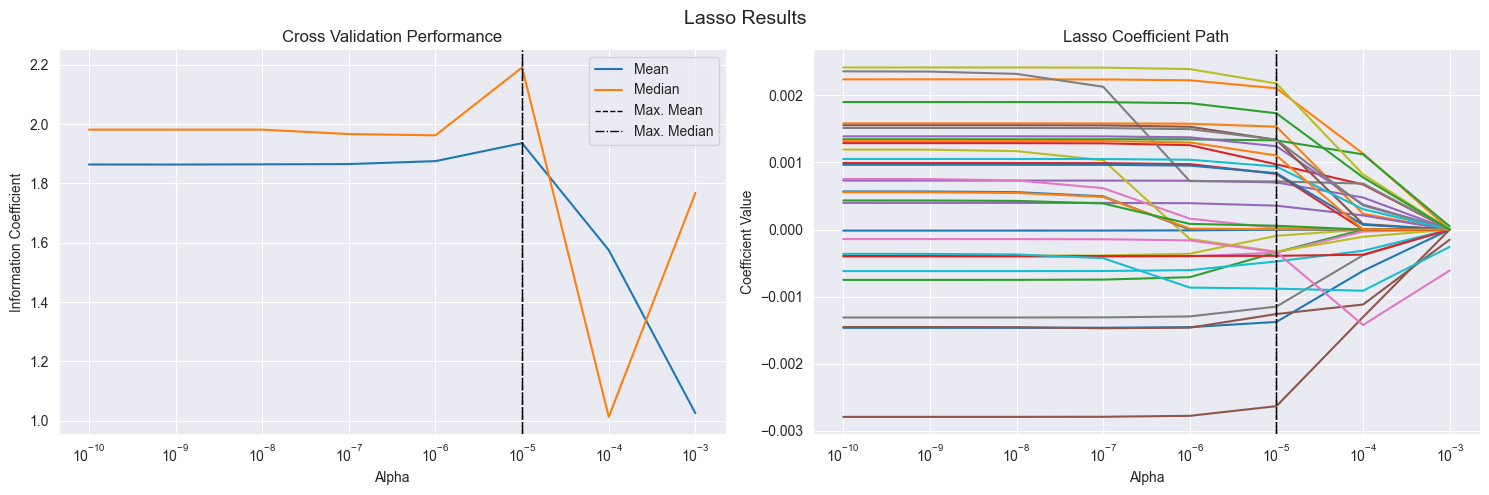

In [159]:
mean_ic_by_alpha = lasso_scores.groupby('alpha')['ic'].mean().reset_index()

fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

scores_by_alpha = lasso_scores.groupby('alpha').ic.agg(['mean', 'median'])
best_alpha_mean = scores_by_alpha['mean'].idxmax()
best_alpha_median = scores_by_alpha['median'].idxmax()

# Plot mean IC by alpha
sns.lineplot(x='alpha', y='ic', data=mean_ic_by_alpha, label='Mean', ax=axes[0])

scores_by_alpha['median'].plot(logx=True, ax=axes[0], label='Median')

axes[0].axvline(best_alpha_mean, ls='--', c='k', lw=1, label='Max. Mean')
axes[0].axvline(best_alpha_median, ls='-.', c='k', lw=1, label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Information Coefficient')
axes[0].set_title('Cross Validation Performance')

lasso_coeffs.plot(logx=True, legend=False, ax=axes[1], title='Lasso Coefficient Path')
axes[1].axvline(best_alpha_mean, ls='--', c='k', lw=1, label='Max. Mean')
axes[1].axvline(best_alpha_median, ls='-.', c='k', lw=1, label='Max. Median')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coefficient Value')

fig.suptitle('Lasso Results', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.9)
sns.despine();

### Lasso IC Distribution and Top 10 Features

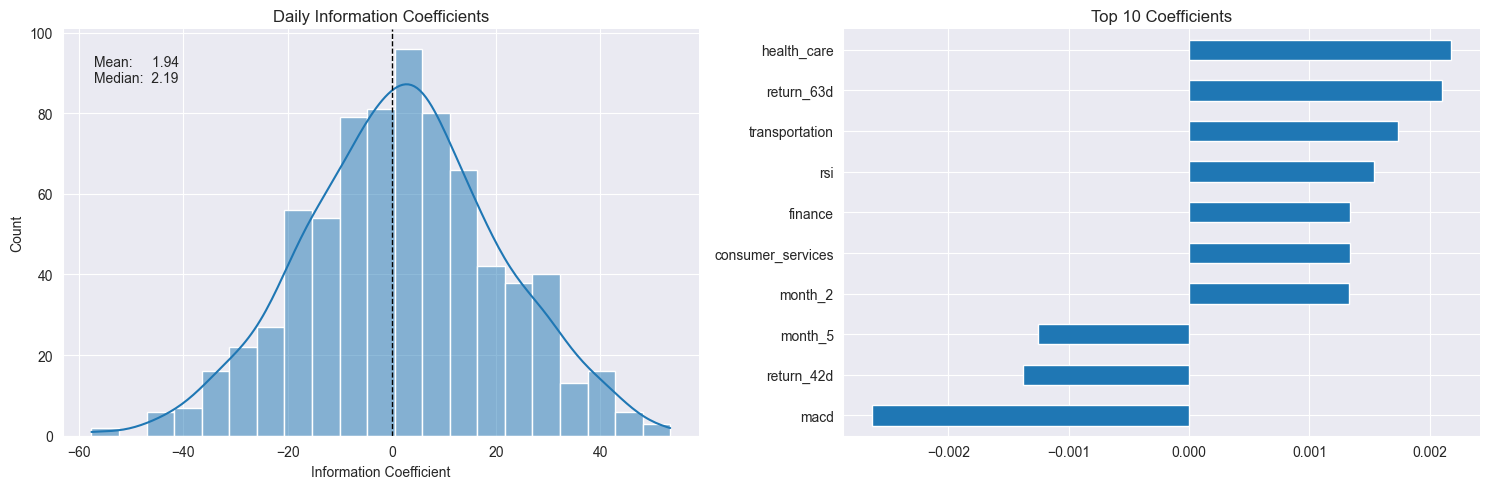

In [160]:
best_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(lasso_scores[lasso_scores.alpha==best_alpha], ax=axes[0])
axes[0].set_title('Daily Information Coefficients')

# top_coeffs = lasso_coeffs.loc[best_alpha].abs().sort_values().head(10).index #THIS IS WRONG, IT'S NOT TOP 10, IT'S BOTTOM 10

# top_coeffs = lasso_coeffs.loc[best_alpha].abs().sort_values(ascending = False).head(10).index
# top_coeffs = lasso_coeffs.loc[best_alpha].abs().sort_values().tail(10).index
top_coeffs = lasso_coeffs.loc[best_alpha].abs().nlargest(10).index
top_coeffs.tolist()
lasso_coeffs.loc[best_alpha, top_coeffs].sort_values().plot.barh(ax=axes[1], title='Top 10 Coefficients')

sns.despine()
fig.tight_layout();

## Compare results

In sum, ridge and lasso regression often produce similar results. Ridge regression often computes faster, but lasso regression also offers continuous feature subset selection by gradually reducing coefficients to zero, hence eliminating features. 

In this particular setting, lasso regression produces the best mean and median IC values, as displayed in Figure 7.12:

In [161]:
best_ridge_alpha = ridge_scores.groupby('alpha').ic.mean().idxmax()
best_ridge_preds = ridge_predictions[ridge_predictions.alpha==best_ridge_alpha]
best_ridge_scores = ridge_scores[ridge_scores.alpha==best_ridge_alpha]

In [162]:
best_lasso_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()
best_lasso_preds = lasso_predictions[lasso_predictions.alpha==best_lasso_alpha]
best_lasso_scores = lasso_scores[lasso_scores.alpha==best_lasso_alpha]

In [163]:
df = pd.concat([lr_scores.assign(Model='Linear Regression'),
               best_ridge_scores.assign(Model='Ridge Regression'),
               best_lasso_scores.assign(Model='Lasso Regression')]).drop('alpha', axis=1)
df.columns = ['IC', 'RMSE', 'Model']

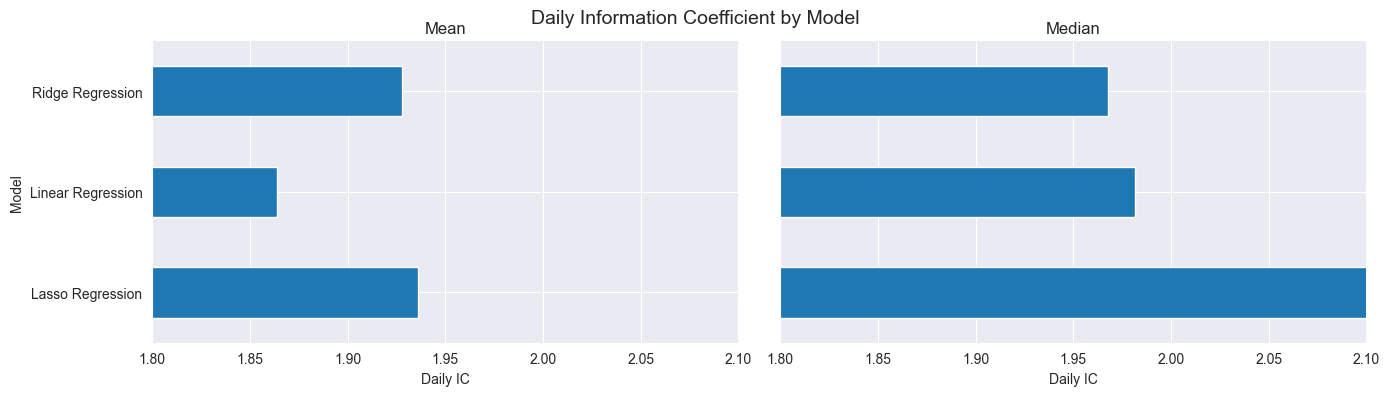

In [164]:
scores = df.groupby('Model').IC.agg(['mean', 'median'])
fig, axes = plt.subplots(ncols=2, figsize=(14,4), sharey=True, sharex=True)

scores['mean'].plot.barh(ax=axes[0], xlim=(1.85, 2), title='Mean')
scores['median'].plot.barh(ax=axes[1], xlim=(1.8, 2.1), title='Median')
axes[0].set_xlabel('Daily IC')
axes[1].set_xlabel('Daily IC')

fig.suptitle('Daily Information Coefficient by Model', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)